In [1]:
import os
from datetime import timedelta
import pickle
import sys


# -----------
sys.path.append(os.path.abspath(".."))
# from utils.inputs import *
# from utils.outputs import *

from utils import (
    validate_inputs,
    load_species_params,
    all_historical_model_run,
    prediction_model_run,
    fflies_output_class,
    PredictionNeededError,
)

# from utils.outputs import fflies_output_class

import pandas as pd

sys.path.append(os.path.abspath("../data"))

data_path = ""

/home/thom/Desktop/CIPM/FruitFlyPheno


In [8]:
import numpy as np
from typing import Dict, Tuple, Union, List
import xarray as xr
from utils.degree_day_equations import single_sine_horizontal_cutoff


def degree_day_core(
    tmin_1d: np.ndarray,
    tmax_1d: np.ndarray,
    start_day: int,
    stages: List[Dict],
    generations: int = 3,
) -> Dict[str, Union[Tuple[int, int, float], Tuple[str, int, float]]]:
    """
    Returns:
    - For complete generations: ('completed', days, accumulated_dd)
    - For incomplete: ('stage_X_gen_Y', current_days, partial_dd)
    """
    current_day = start_day
    total_days = len(tmin_1d)

    for gen in range(1, generations + 1):
        stage_accumulator = 0.0

        for stage_idx, stage in enumerate(stages):
            stage_dd = 0.0
            days_in_stage = 0
            while current_day < total_days:
                # Calculate degree days for all remaining days
                dd = single_sine_horizontal_cutoff(
                    tmin_1d[current_day],
                    tmax_1d[current_day],
                    stage["LTT"],
                    stage["UTT"],
                )

                stage_dd += dd
                stage_accumulator += dd
                days_in_stage += 1
                current_day += 1

                if stage_accumulator >= stage["dd_threshold"]:
                    break

            if stage_accumulator < stage["dd_threshold"]:
                # Incomplete stage
                days_elapsed = current_day - start_day
                return days_elapsed, stage_dd, gen, stage_idx

        # Generation completed
        if gen == generations:
            days_elapsed = current_day - start_day
            return days_elapsed, stage_dd, gen, stage_idx

    raise ValueError("generation accumulation failed") #should not reach here

def spatial_wrapper(
    tmin_xr: xr.DataArray,  # (time, lat, lon)
    tmax_xr: xr.DataArray,  # (time, lat, lon)
    start_day: int,
    stages: List[Dict],
    generations: int = 3,
) -> xr.Dataset:
    """Simplified wrapper matching core outputs"""
    days, dd, gen, stage = xr.apply_ufunc(
        degree_day_core,
        tmin_xr,
        tmax_xr,
        input_core_dims=[["t"], ["t"]],
        kwargs={"start_day": start_day, "stages": stages, "generations": generations},
        output_core_dims=[[], [], [], []],
        output_dtypes=[int, float, int, int],
        vectorize=True,
        dask="parallelized",
        exclude_dims={"t"},
    )

    return xr.Dataset(
        {
            "days_elapsed": days,
            "accumulated_dd": dd,
            "current_gen": gen,
            "current_stage": stage,
        }
    )

In [ ]:
import numpy as np
import xarray as xr
from typing import Dict, List

def forecast_completion(
    historical_data: xr.Dataset,    # Contains 'tmin' and 'tmax' (year, time, lat, lon)
    partial_results: xr.Dataset,    # Output from spatial_wrapper()
    stages: List[Dict],
    generations: int = 3
) -> xr.Dataset:
    """
    Generates 20 completion forecasts using historical weather patterns.
    
    Returns:
        xarray Dataset with dimensions (year, lat, lon) containing:
        - completion_day: Total days needed (current partial + historical)
        - final_gen: Highest completed generation (1-3)
        - is_complete: Boolean whether target generations were reached
    """
    # 1. Prepare output arrays
    n_years = len(historical_data.year)
    shape = (n_years, len(partial_results.lat), len(partial_results.lon))
    
    completion_days = xr.DataArray(
        np.full(shape, np.nan, dtype=np.int32),
        dims=('year', 'lat', 'lon'),
        coords={
            'year': historical_data.year,
            'lat': partial_results.lat,
            'lon': partial_results.lon
        }
    )
    
    final_gens = xr.DataArray(
        np.full(shape, np.nan, dtype=np.int8),
        dims=('year', 'lat', 'lon'),
        coords=completion_days.coords
    )

    # 2. Process each historical year
    for i, year in enumerate(historical_data.year.values):
        # Combine current partial year + historical weather
        combined_tmin = xr.concat([
            current_year_data['tmin'],
            historical_data['tmin'].sel(year=year)
        ], dim='time')
        
        combined_tmax = xr.concat([
            current_year_data['tmax'],
            historical_data['tmax'].sel(year=year)
        ], dim='time')

        # Run simulation for this year's completion
        forecast = xr.apply_ufunc(
            degree_day_core,
            combined_tmin,
            combined_tmax,
            input_core_dims=[['time'], ['time']],
            kwargs={
                'start_day': 0,  # Start from beginning of combined data
                'stages': stages,
                'generations': generations
            },
            output_core_dims=[[], [], [], []],
            output_dtypes=[int, float, int, int],
            vectorize=True,
            dask='parallelized'
        )

        # Store results
        completion_days[i] = forecast[0]  # days_elapsed
        final_gens[i] = forecast[2]       # current_gen

    # 3. Package results
    return xr.Dataset({
        'completion_day': completion_days,
        'final_gen': final_gens,
        'is_complete': (final_gens >= generations)
    })

In [ ]:
#if an area is not complete, run the prediction model. 

import xarray as xr
import numpy as np

def predict_generations(
    current_data: xr.Dataset,  # tmin/tmax (time, lat, lon) - days since start_date
    historical_data: xr.Dataset,  # tmin/tmax (year, time, lat, lon)
    stages: List[Dict],
    generations: int = 3
) -> xr.Dataset:
    """
    Predicts development using:
    1. Current year data until available
    2. Continues with each historical year's data
    
    Returns xr.Dataset with (year, lat, lon) containing:
    - total_days: Days from start to completion
    - completed: Boolean whether full development occurred
    """
    
    # Get dimensions
    n_years = len(historical_data.year)
    n_days_current = len(current_data.time)
    n_days_historical = len(historical_data.time)
    
    # Pre-allocate output arrays
    total_days = xr.DataArray(
        np.empty((n_years, len(current_data.lat), len(current_data.lon)), dtype=np.int32),
        dims=('year', 'lat', 'lon'),
        coords={
            'year': historical_data.year,
            'lat': current_data.lat,
            'lon': current_data.lon
        }
    )
    
    completed = xr.DataArray(
        np.empty((n_years, len(current_data.lat), len(current_data.lon)), dtype=bool),
        dims=('year', 'lat', 'lon'),
        coords=total_days.coords
    )

    # Process each historical year
    for i, year in enumerate(historical_data.year.values):
        # Efficiently construct combined array without copying
        combined_tmin = xr.concat([
            current_data['tmin'],
            historical_data['tmin'].sel(year=year)
        ], dim='time')
        
        combined_tmax = xr.concat([
            current_data['tmax'],
            historical_data['tmax'].sel(year=year)
        ], dim='time')
        
        # Run simulation
        days, _, gen, _ = xr.apply_ufunc(
            degree_day_core,
            combined_tmin,
            combined_tmax,
            input_core_dims=[['time'], ['time']],
            kwargs={'start_day': 0, 'stages': stages, 'generations': generations},
            output_core_dims=[[], [], [], []],
            output_dtypes=[int, float, int, int],
            vectorize=True,
            dask='parallelized'
        )
        
        # Store results
        total_days[i] = days
        completed[i] = (gen == generations)
    
    return xr.Dataset({
        'total_days': total_days,
        'completed': completed,
        'used_current_days': n_days_current * xr.ones_like(total_days.isel(year=0))
    })

In [ ]:
def predict_generations(
    current_data: xr.Dataset,  # tmin/tmax (time, lat, lon) - days since start_date
    historical_data: xr.Dataset,  # tmin/tmax (year, time, lat, lon)
    stages: List[Dict],
    detection_date: pd.Timestamp,

    generations: int = 3,
    start_year: int = 2000,
    end_year: int = 2020,
    
) -> xr.Dataset:
    """
    Predicts development using:
    1. Current year data until available
    2. Continues with each historical year's data
    
    Returns xr.Dataset with (year, lat, lon) containing:
    - total_days: Days from start to completion
    - completed: Boolean whether full development occurred
    """
        
    detection_day = (detection_date - pd.Timestamp("2000-01-01")).days
    print(detection_day)

    

In [ ]:

historical_year = 2000
detection_day_of_year = detection_date.dayofyear
historical_day of_year = historical_data.time.dt.dayofyear

<bound method _Timestamp.day_name of Timestamp('2023-10-01 00:00:00')>

In [9]:
# lets test the core first
data_path = os.path.abspath(os.path.join("..", "")) #".." and "data"
cache_path = os.path.join(data_path, "cache_temp/pred_cache.pkl") #remove cache temp
print(cache_path)
if cache_path and os.path.exists(cache_path):
    with open(cache_path, "rb") as cache_file:
        raw_PRISM = pickle.load(cache_file)

tmin_xr = raw_PRISM["tmin"]
tmax_xr = raw_PRISM["tmax"]
tmax_single_sample = tmax_xr.isel(latitude=0, longitude=0)
tmin_single_sample = tmin_xr.isel(latitude=0, longitude=0)

start_day = 0
target_species = "off"
stages = load_species_params(target_species, os.path.abspath(os.path.join("..", "data")))

test = spatial_wrapper(tmin_xr, tmax_xr, start_day, stages, generations=3)


test_core = degree_day_core(
    tmax_single_sample.values,
    tmin_single_sample.values,
    start_day,
    stages,
    generations=3,
)

/home/thom/Desktop/CIPM/FruitFlyPheno/cache_temp/pred_cache.pkl


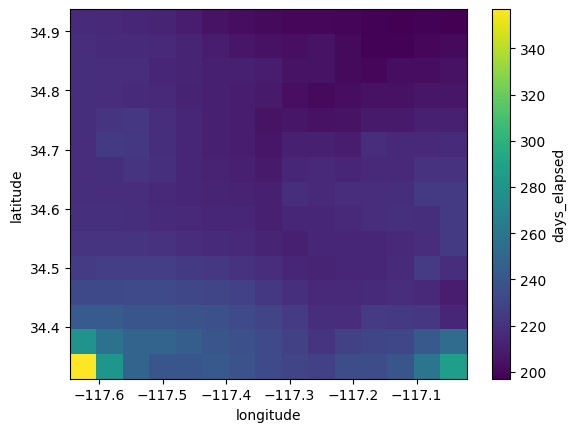

In [12]:
test['days_elapsed'].plot()

In [15]:
test_core

{'status': 'completed', 'days': 236, 'dd': np.float64(637.5014963150024)}

AttributeError: 'NoneType' object has no attribute 'keys'

In [ ]:
def forecast_with_historical(
    current_year_data: xr.Dataset,  # tmin/tmax up to current day (time, lat, lon)
    historical_data: xr.Dataset,  # 20 years of tmin/tmax (year, time, lat, lon)
    incomplete_results: xr.Dataset,  # From original run (lat, lon)
    stages: List[Dict],
    generations: int = 3,
) -> xr.Dataset:
    """
    Runs completion forecasts using historical data patterns.

    Returns:
        xr.Dataset with dimensions (year, lat, lon) containing:
        - completion_day: Total days needed (current + historical)
        - generation: Final completed generation
    """

    # Get current progress status
    status_parts = incomplete_results["status"].str.split("_")
    current_stage = status_parts.str[1].astype(int)
    current_gen = status_parts.str[3].astype(int)

    # Prepare output arrays
    n_years = len(historical_data.year)
    shape = (n_years, len(incomplete_results.lat), len(incomplete_results.lon))
    completion_days = np.full(shape, np.nan, dtype=int)
    final_generations = np.full(shape, np.nan, dtype=int)

    # Process each historical year
    for i, year in enumerate(historical_data.year.values):
        # Combine current + historical weather
        combined_tmin = xr.concat(
            [current_year_data["tmin"], historical_data["tmin"].sel(year=year)],
            dim="time",
        )

        combined_tmax = xr.concat(
            [current_year_data["tmax"], historical_data["tmax"].sel(year=year)],
            dim="time",
        )

        # Run full simulation starting from day 0
        results = xr.apply_ufunc(
            your_original_core_function,  # Use your exact existing function
            combined_tmin,
            combined_tmax,
            input_core_dims=[["time"], ["time"]],
            kwargs={"stages": stages, "generations": generations},
            vectorize=True,
            dask="parallelized",
            output_dtypes=[object],  # For dictionary results
        )

        # Extract completion metrics
        for lat in incomplete_results.lat.values:
            for lon in incomplete_results.lon.values:
                cell_result = results.sel(lat=lat, lon=lon).item()
                completion_days[i, lat, lon] = cell_result[f"F{current_gen}"][-1][0]
                final_generations[i, lat, lon] = (
                    current_gen if "completed" in cell_result else current_gen - 1
                )

    # Package results
    return xr.Dataset(
        {
            "completion_day": (("year", "lat", "lon"), completion_days),
            "final_generation": (("year", "lat", "lon"), final_generations),
        },
        coords={
            "year": historical_data.year,
            "lat": incomplete_results.lat,
            "lon": incomplete_results.lon,
        },
    )



In [ ]:
# Original simulation
results = fflies_model_2_multistage(current_year_data, ...)

# Get incomplete cells
incomplete = results.where(results.status != "completed", drop=True)

# Run forecasts
forecasts = forecast_with_historical(
    current_year_data, historical_weather, incomplete, stages
)

# Calculate statistics
mean_days = forecasts.completion_day.mean(dim="year")
prob_completed = (forecasts.final_generation >= 3).mean(dim="year")

In [ ]:
def run_plot_DD(
    start_dates,
    coordinates,
    target_species,
    historical_data_buffer=400,
    cache_path=os.path.join(data_path, "cache/pred_cache.pkl"),
    context_map=False,
    save_output=False,
    all_historical=None,
    force_prediction=False,
):
    """
    Generates a plot of completion dates for a given species at specified coordinates.

    Parameters:
    ----------
    start_dates : list of datetime
        List of start dates corresponding to each coordinate.
    coordinates : list of tuples (lat, lon)
        List of latitude and longitude pairs.
    target_species : str
        Name of the species to model.
    days_of_data : int
        Number of days of data to fetch - usually 180-200 is sufficient
    historical_data_buffer : int
        Number of days to buffer historical data for model run.
    cache_path : str
        Path to cache file for storing fetched data.
    context_map : bool
        If True, generates a context map for a single point.
    save_output : bool
        If True, saves the output data to a tiff file.
    Returns:
    -------
    matplotlib.figure.Figure
        A plot displaying degree-day completion for the given coordinates.

    Raises:
    ------
    ValueError:
        If the number of coordinates and dates do not match.
        If no coordinates are provided.
        If the start date is too early or the end date is in the future.
    """
    ###################
    ##Input Validation#
    ###################
    all_historical = validate_inputs(start_dates, coordinates, historical_data_buffer)

    # a bounding box if we have multiple points, a context map if we have a single point
    # loaded from .json file
    fly_params = load_species_params(target_species, data_path)

    # setup Modelvariables
    first_date = min(start_dates)
    last_date = max(start_dates) + timedelta(days=historical_data_buffer)
    n_days_data = (last_date - first_date).days

    ##########
    ##Model##
    ##########
    if all_historical:
        try:
            return all_historical_model_run(
                coordinates,
                start_dates,
                fly_params,
                n_days_data,
                cache_path,
                context_map,
            )
        except PredictionNeededError: #triggers if we assume we have all historical data but we actually need to predict
            all_historical = False
    if force_prediction or not all_historical:
        return prediction_model_run(
            coordinates,
            start_dates,
            fly_params,
            n_days_data,
            cache_path,
            produce_plot=False,
        )
        # predict

In [3]:
output = run_plot_DD(
    [pd.to_datetime("2025-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=False,
    cache_path=os.path.join(data_path, "cache/pred_cache.pkl"),
)

In [4]:
print(output)

fflies_output_class(finish_date_list=[237, 230, 230, 245, 231], figure=<Figure size 640x480 with 0 Axes>, value=None, array=<xarray.DataArray ()> Size: 8B
array(nan))


In [ ]:
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=True,
    cache_path=os.path.join(data_path, "cache/cache[deleted].pkl"),
)

AttributeError: 'str' object has no attribute 'strptime'

In [ ]:
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
)

NameError: name 'run_plot_DD' is not defined

run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=False,
)
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=True,
)
### Why is map not plotting?

In [ ]:
# test statements
"""
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",


run_plot_DD(
    [pd.to_datetime("2002-01-01"), pd.to_datetime("2002-05-01")],
    [(34.63115, -117.338321), (34.68115, -117.336321)],
    "Mexfly",
)
"""

'\nrun_plot_DD(\n    [pd.to_datetime("2002-01-01")],\n    [(34.63115, -117.338321)],\n    "Mexfly",\n\n\nrun_plot_DD(\n    [pd.to_datetime("2002-01-01"), pd.to_datetime("2002-05-01")],\n    [(34.63115, -117.338321), (34.68115, -117.336321)],\n    "Mexfly",\n)\n'

In [ ]:
import os


# Parameters
start_date = "2020-01-01"
bbox = (-117.63832099999999, -117.038321, 34.33115, 34.931149999999995)
cache_path = "cache/pred_cache.pkl"

# Ensure the cache directory exists
os.makedirs(os.path.dirname(cache_path), exist_ok=True)

# Fetch the data
ncss_data = fetch_ncss_data(start_date=start_date, bbox=bbox)

# Save the data to the cache
with open(cache_path, "wb") as cache_file:
    pickle.dump(ncss_data, cache_file)

print(f"NCSS data saved to {cache_path}")

NCSS data saved to cache/pred_cache.pkl
